# AI NASA


## Charger les données


In [24]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('asteroids.db')
query ="SELECT * FROM asteroid"
df = pd.read_sql_query(query, conn)
df.head()

,id,name,absolute_magnitude_h,diameter_min_km,diameter_max_km,is_hazardous,velocity_kph,miss_distance_au,miss_distance_km,moid,eccentricity,inclination
0,2000433,433 Eros (A898 PA),10.38,22.312846,49.893041,0,20083.029075,0.314929,4.711273e+07,0.148353,0.222836,10.828467
1,2000719,719 Albert (A911 TB),15.59,2.025606,4.529393,0,12405.704359,1.708774,2.556290e+08,0.201318,0.546596,11.573111
2,2000887,887 Alinda (A918 AA),13.81,4.597852,10.281109,0,25545.505252,0.136779,2.046181e+07,0.079677,0.571170,9.400060
3,2001036,1036 Ganymed (A924 UB),9.18,38.775283,86.704169,0,22693.918951,1.956257,2.926518e+08,0.343339,0.533213,26.680736
4,2001221,1221 Amor (1932 EA1),17.37,0.892391,1.995446,0,38772.626612,0.183912,2.751287e+07,0.107969,0.434632,11.868823


## Creation du test train


In [25]:
from sklearn.model_selection import train_test_split

X = df.drop(['is_hazardous','id','name'], axis=1) 
y = df['is_hazardous']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# On normalise les données numériques
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)







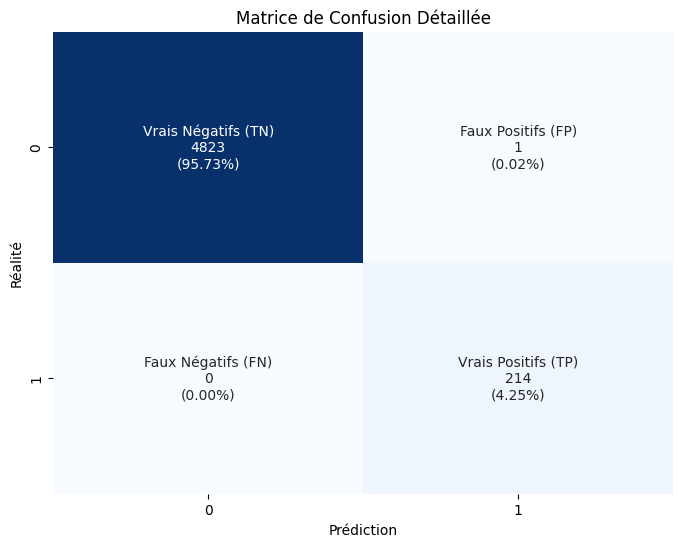

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

# Préparation des labels pour chaque case
group_names = ['Vrais Négatifs (TN)', 'Faux Positifs (FP)', 'Faux Négatifs (FN)', 'Vrais Positifs (TP)']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]

# On combine le tout : Nom + Nombre + Pourcentage
labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion Détaillée')
plt.show()

## Tentative sans la colonne moid


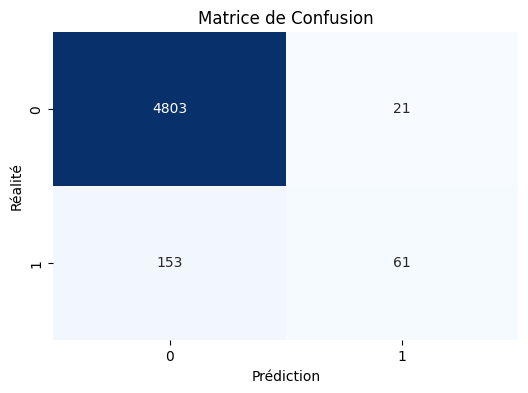

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4824
           1       0.74      0.29      0.41       214

    accuracy                           0.97      5038
   macro avg       0.86      0.64      0.70      5038
weighted avg       0.96      0.97      0.96      5038



In [27]:
X = df.drop(['is_hazardous','id','name','moid'], axis=1) 
y = df['is_hazardous']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# On normalise les données numériques
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion')
plt.show()

print(classification_report(y_test, y_pred))


## 3eme essai en utilisant le SMOTE

Taille avant SMOTE : {0: 19296, 1: 855}
Taille après SMOTE : {0: 19296, 1: 19296}


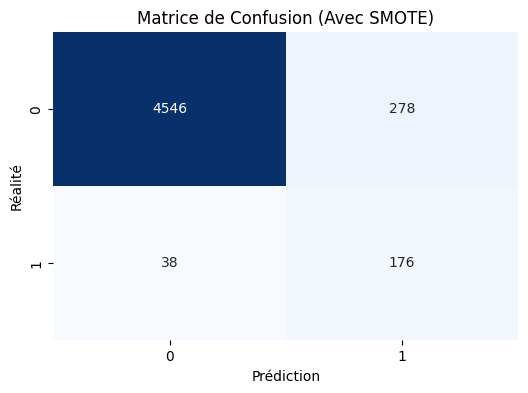

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      4824
           1       0.39      0.82      0.53       214

    accuracy                           0.94      5038
   macro avg       0.69      0.88      0.75      5038
weighted avg       0.97      0.94      0.95      5038



In [28]:
# 1. Importation de SMOTE
from imblearn.over_sampling import SMOTE 

# Tes données
X = df.drop(['is_hazardous','id','name','moid'], axis=1) 
y = df['is_hazardous']

# 2. Le Split (Toujours en premier !)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. La Normalisation
scaler = StandardScaler()

# On fit sur le train uniquement
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # On transforme le test avec les stats du train

# --- 4. C'EST ICI QU'ON APPLIQUE SMOTE ---
print("Taille avant SMOTE :", y_train.value_counts().to_dict())

smote = SMOTE(random_state=42)
# On crée les données synthétiques (X_resampled, y_resampled)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Taille après SMOTE :", y_train_resampled.value_counts().to_dict())
# Tu devrais voir qu'il y a maintenant autant de 0 que de 1 (50/50)

# 5. Entraînement du modèle
# Note : J'ai enlevé "class_weight='balanced'" car SMOTE a déjà équilibré les données !
model = RandomForestClassifier(n_estimators=100, random_state=42)

# IMPORTANT : On entraîne sur les données "resampled" (avec les faux astéroïdes)
model.fit(X_train_resampled, y_train_resampled)

# 6. Prédiction 
# IMPORTANT : On prédit sur le X_test ORIGINAL (sans fake data)
y_pred = model.predict(X_test_scaled)

# 7. Affichage
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion (Avec SMOTE)')
plt.show()

print(classification_report(y_test, y_pred))

## 4eme essai avec parametre opti

Taille avant SMOTE : {0: 19296, 1: 855}
Taille après SMOTE : {0: 19296, 1: 19296}


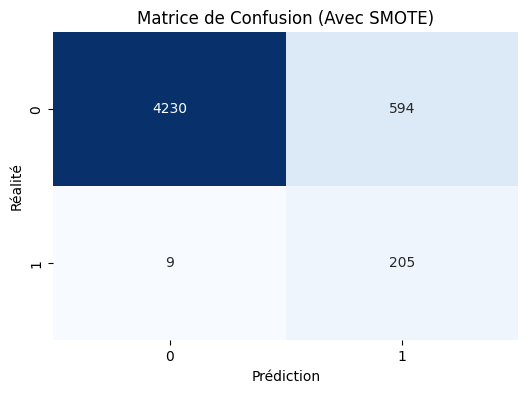

              precision    recall  f1-score   support

           0       1.00      0.88      0.93      4824
           1       0.26      0.96      0.40       214

    accuracy                           0.88      5038
   macro avg       0.63      0.92      0.67      5038
weighted avg       0.97      0.88      0.91      5038



In [29]:
# 1. Importation de SMOTE
from imblearn.over_sampling import SMOTE 

# Tes données
X = df.drop(['is_hazardous','id','name','moid'], axis=1) 
y = df['is_hazardous']

# 2. Le Split (Toujours en premier !)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. La Normalisation
scaler = StandardScaler()

# On fit sur le train uniquement
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # On transforme le test avec les stats du train

# --- 4. C'EST ICI QU'ON APPLIQUE SMOTE ---
print("Taille avant SMOTE :", y_train.value_counts().to_dict())

smote = SMOTE(random_state=42)
# On crée les données synthétiques (X_resampled, y_resampled)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Taille après SMOTE :", y_train_resampled.value_counts().to_dict())
# Tu devrais voir qu'il y a maintenant autant de 0 que de 1 (50/50)

# 5. Entraînement du modèle
# Note : J'ai enlevé "class_weight='balanced'" car SMOTE a déjà équilibré les données !
model = RandomForestClassifier(n_estimators=100, random_state=42,min_samples_leaf=1,max_depth=10)

# IMPORTANT : On entraîne sur les données "resampled" (avec les faux astéroïdes)
model.fit(X_train_resampled, y_train_resampled)

# 6. Prédiction 
# IMPORTANT : On prédit sur le X_test ORIGINAL (sans fake data)
y_pred = model.predict(X_test_scaled)

# 7. Affichage
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion (Avec SMOTE)')
plt.show()

print(classification_report(y_test, y_pred))

In [30]:
from sklearn.model_selection import GridSearchCV

# On définit une "grille" de paramètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# On configure le chercheur
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,                 # Validation croisée en 3 parties
    scoring='recall',     # IMPORTANT : On dit à l'IA "Maximise le RECALL (Sécurité)" !
    n_jobs=-1,            # Utilise tous les cœurs du CPU
    verbose=2
)

# On lance la recherche (sur les données SMOTE)
print("Recherche des meilleurs paramètres en cours...")
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Meilleurs paramètres trouvés : {grid_search.best_params_}")

# Le meilleur modèle est déjà prêt à l'emploi
best_model = grid_search.best_estimator_

Recherche des meilleurs paramètres en cours...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Meilleurs paramètres trouvés : {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}


## Essai avec La Régression Logistique

## Essai avec KNN

# Essai avec Naive Bayes